## Genetic compression search on LeNet-5 

In [1]:
PATH_PREFIX = '../../'
import sys
sys.path.append(PATH_PREFIX)

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from data.utils.mnist_utils import *
from models.lenet.lenet import LeNet5
from utils.weight_sharing import *
from utils.genetic import GeneticController, Individual
from utils.plot import *
from utils.fitness_controller import FitnessController

Setting parameters (for the genetic search settings look in `utils.genetic_config.py`)

In [3]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings 
NET_TYPE = 'relu'
NET_PATH = os.path.join(PATH_PREFIX, f'models/lenet/saves/lenet_{NET_TYPE}.save')

# dataset settings
DATA_PATH = os.path.join(PATH_PREFIX, 'data')

# ga iter count
NUM_GENERATIONS = 36
NUM_PULATION = 12

# ga search settings
CHROMOSOME_RANGES = [range(1, 51) for _ in range(5)]

# ga save settings
SAVE_EVOL_FILE = os.path.join(PATH_PREFIX, 'results/test_GA_save.csv')
SAVE_EVERY = 1

# target position
TARGET = [0.99, 12.0]
TARGET_LOW_LIMIT = [0.965, 1.0]
LOCK_TARGET = False
TARGET_UPDATE_OFFSET = [0.001, 0.1]

#compression optimization settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = None #[0, 0, 0, 0, 0]
PREC_REDUCT = ['f2' for _ in range(5)]  #None # ['f4', 'f4', 'f4', 'f4', 'f4']
CLUST_MOD_FOCUS = None #[5, 5, 5, 5, 5]
CLUST_MOD_SPREAD = None #[0, 0, 0, 0, 0]

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_TRESHOLD = 0.97
RANGE_OPTIMIZATION_FILE = os.path.join(PATH_PREFIX, f'models/lenet/saves/lenet_{NET_TYPE}_layer_perf_{PREC_REDUCT[0]}.csv')

Geting somewhat trained LeNet-5

In [4]:
dataset = MnistDataset(BATCH_SIZE, DATA_PATH, val_split=0.5)
model = LeNet5(N_CLASSES, NET_TYPE)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [5]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_test, lam_opt, lam_train)
ws_controller.set_reset()

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [6]:
def fitness_vals_fc(individual:Individual):
    # reset the net
    ws_controller.reset()
    
    # share weigts by particle
    if individual.data is None:
        individual.data = ws_controller.share(individual.chromosome, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, CLUST_MOD_FOCUS, CLUST_MOD_SPREAD)
    
    return [individual.data['accuracy'], individual.data['compression']]

def fit_from_vals(data, targ_vals):

    return 1 / math.sqrt(pow(1 - (data['accuracy']/targ_vals[0]), 2) + pow(1 - (data['compression']/targ_vals[1]), 2))

Defining logging function and elit dealing function

In [7]:
data = {
    'generation': [],
    'chromosome': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'generation' : 'uint8',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

evol_data = pd.read_csv(SAVE_EVOL_FILE).astype(data_types) if os.path.exists(SAVE_EVOL_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(gen_cont:GeneticController):
    global evol_data

    new_data = copy.deepcopy(data)

    for indiv in gen_cont.population:

        new_data['generation'].append(gen_cont.generation)
        new_data['chromosome'].append(indiv.chromosome)
        new_data['accuracy'].append(indiv.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
        new_data['compression'].append(indiv.data['compression'])
        new_data['share_t'].append(indiv.data['times']['share'])
        new_data['train_t'].append(indiv.data['times']['train'])
        new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    evol_data = evol_data.append(pd.DataFrame(new_data).astype(data_types))
    if gen_cont.generation % SAVE_EVERY == SAVE_EVERY - 1:
        evol_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_EVOL_FILE), exist_ok=True)
        evol_data.to_csv(SAVE_EVOL_FILE, index=False)
    
def deal_elit(population):
    for individual in population:
        if individual.data is not None:
            individual.data['times'] = {
                'share': 0,
                'train': 0,
                'test': 0
            }


Setting ranges with optimization

In [8]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    CHROMOSOME_RANGES = ws_controller.get_optimized_layer_ranges(CHROMOSOME_RANGES, lam_test_inp, RANGE_OPTIMIZATION_TRESHOLD, 
        savefile=RANGE_OPTIMIZATION_FILE)

for c_range in CHROMOSOME_RANGES:
    print(len(c_range))

49
47
47
48
47


Run evolution

In [9]:
fit_controll = FitnessController(TARGET, fitness_vals_fc, fit_from_vals, target_update_offset=TARGET_UPDATE_OFFSET, 
    lock=LOCK_TARGET, target_limit=TARGET_LOW_LIMIT)
genetic = GeneticController(CHROMOSOME_RANGES, NUM_PULATION, fit_controll)

if evol_data.size != 0:
    genetic.load_from_pd(evol_data, verbose=True)

genetic.run(NUM_GENERATIONS, logger_fc, deal_elit=deal_elit, verbose=True)

Generation 1/36 (1) evaluated, best fitness 3.511350838959625


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


Generation 2/36 (2) evaluated, best fitness 3.511350838959625


See output

In [10]:
evol_data.tail()

,generation,chromosome,accuracy,accuracy_loss,compression,share_t,train_t,acc_t,fitness
475,39,"[3, 30, 4, 5, 4]",0.9720,0.0126,11.836569,0.443005,0.0,0.669608,NaN
476,39,"[3, 4, 4, 5, 30]",0.9710,0.0136,11.828853,0.442998,0.0,0.674934,NaN
477,39,"[3, 4, 37, 5, 4]",0.9780,0.0066,11.642787,1.246511,0.0,0.667381,NaN
478,39,"[3, 4, 38, 23, 4]",0.9762,0.0084,10.780334,1.460125,0.0,0.668115,NaN
479,39,"[3, 28, 20, 5, 4]",0.9794,0.0052,9.923812,1.011415,0.0,0.742901,NaN


Plotting data

Text(0.5, 1.0, 'Genetic Algorithm on LeNet-5')

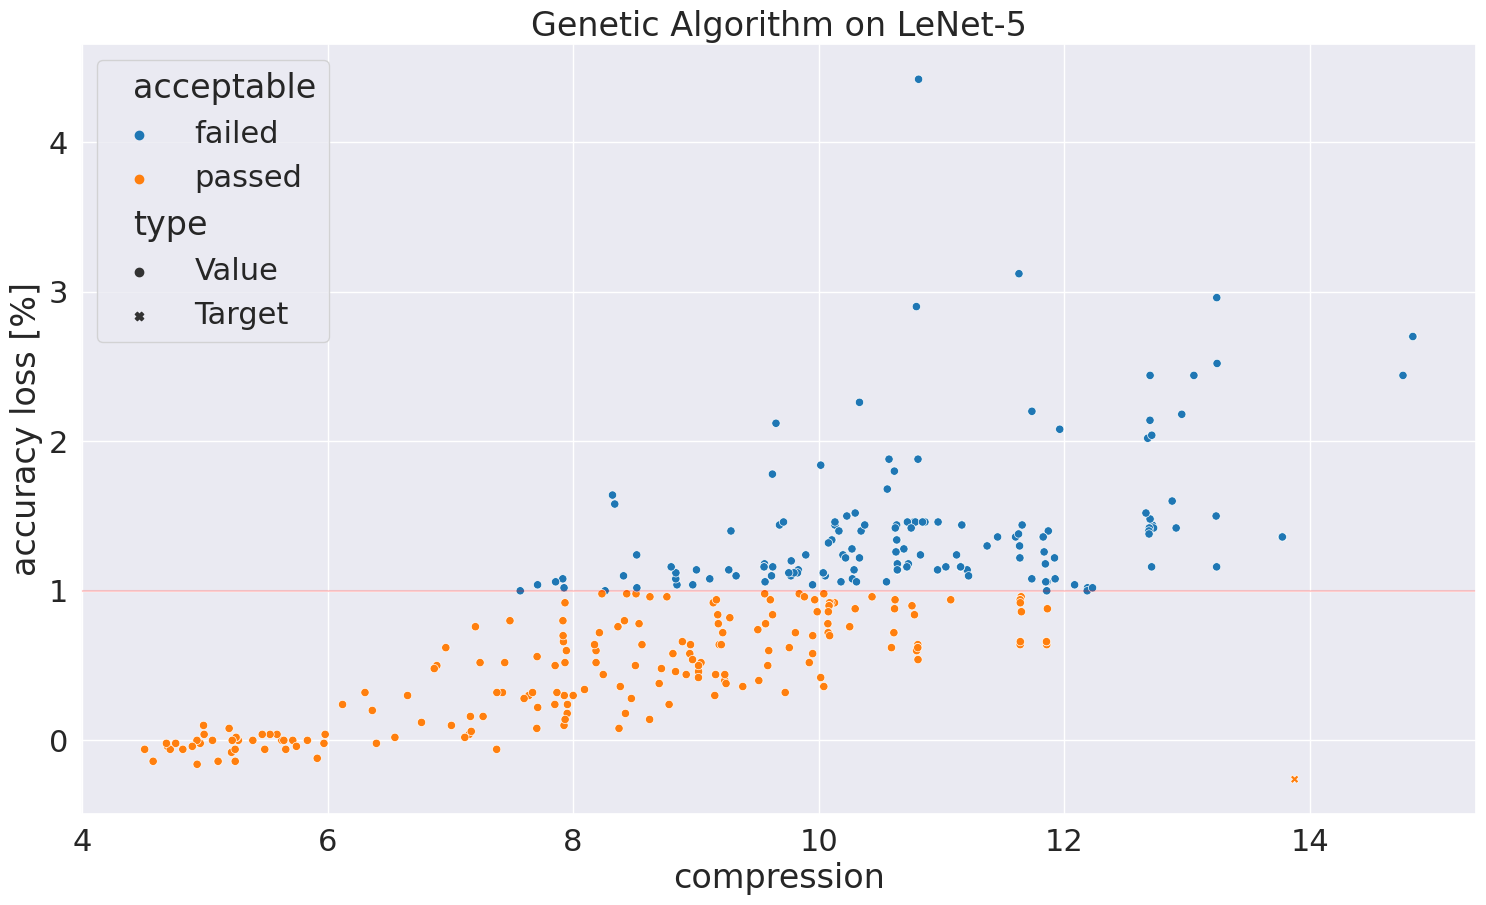

In [11]:
plot_alcr(evol_data, target=fit_controll.targ)
plt.title('Genetic Algorithm on LeNet-5')